In [1]:
%pylab inline
import radvel

import corner
import copy

from scipy import optimize
rc('savefig',dpi=120)

# Convenient function for plotting fits
def plot_results(like):
    fig = gcf()
    errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plot(ti, like.model(ti))
    xlabel('Time')
    ylabel('RV')
    draw()

Populating the interactive namespace from numpy and matplotlib


Intialize Keplerian model parameters
====================================

In [2]:
params = radvel.Parameters(1,basis='per tc secosw sesinw k')
params['k1'] = radvel.Parameter(value=1)
params['per1'] = radvel.Parameter(value=1)
params['secosw1'] = radvel.Parameter(value=0.1)
params['sesinw1'] = radvel.Parameter(value=+0.2)
params['tc1'] = radvel.Parameter(value=0.)
rv_mod = radvel.RVModel(params)

Generate Synthetic Data
=======================

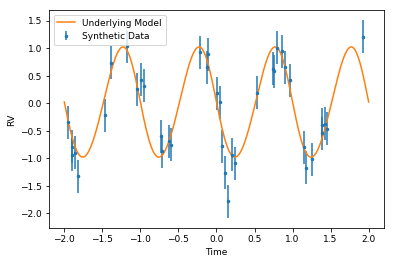

In [3]:
t = np.random.random_sample(40)
t = t * 4 - 2
t = np.sort(t)
ti = np.linspace(-2,2,400)
errvel = 0.3
syn_rv = rv_mod(t) + randn(t.size)*errvel
errorbar(t,syn_rv,yerr=errvel,fmt='.',label='Synthetic Data')
plot(ti,rv_mod(ti),label='Underlying Model')
xlabel('Time')
ylabel('RV')
legend()

Generate a likelihood
=====================

In [4]:
like_syn = radvel.likelihood.RVLikelihood(rv_mod,t,syn_rv,zeros(t.size)+errvel)
like_syn.params['gamma'] = radvel.Parameter(value=0)
like_syn.params['jit'] = radvel.Parameter(value=errvel)

truths = copy.deepcopy(like_syn.params) # Store away model parameters for later reference
like_syn.params.update(dict(k1=radvel.Parameter(value=3),
                            secosw1=radvel.Parameter(value=0.1),
                            sesinw1=radvel.Parameter(value=0.1),
                            tc1=radvel.Parameter(value=0.1))) # perturb the starting guess

like_syn.params['jit'].vary = False # Don't vary jitter


Perform a maximum likelihood fit
===============================

 final_simplex: (array([[ 0.99499696,  0.03494167, -0.11435701,  0.54574816,  1.04391467,
         0.01990284, -0.02425959, -0.0248727 ],
       [ 0.99500534,  0.03494478, -0.11435102,  0.54573671,  1.04396907,
         0.01990226, -0.02425894, -0.02487209],
       [ 0.99500739,  0.03494308, -0.11434465,  0.54571956,  1.04390673,
         0.01990167, -0.02425784, -0.02487108],
       [ 0.99500068,  0.03494835, -0.11436553,  0.54577609,  1.04401401,
         0.0199037 , -0.02426149, -0.02487425],
       [ 0.9950002 ,  0.03495324, -0.11435228,  0.54575067,  1.04385548,
         0.01990278, -0.02426019, -0.02487244],
       [ 0.99499814,  0.03495049, -0.11437571,  0.54580387,  1.04397731,
         0.01990479, -0.02426332, -0.02487563],
       [ 0.99500176,  0.03494779, -0.11439528,  0.5458477 ,  1.04392223,
         0.01990658, -0.02426589, -0.02487804],
       [ 0.99500158,  0.03493393, -0.11435799,  0.54574114,  1.04388317,
         0.01990272, -0.02425884, -0.02487245],
       [ 0.9949

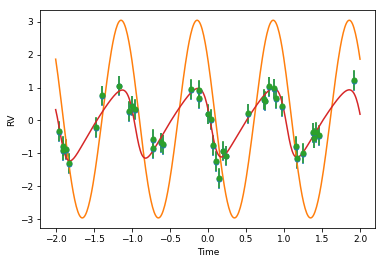

In [5]:
plot_results(like_syn) # Plot initial model
res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='Nelder-Mead' )
#res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='L-BFGS-B' )
print(res)
print(like_syn)
plot_results(like_syn) # plot best fit model

Instantiate a posterior object
===============================

In [6]:
post = radvel.posterior.Posterior(like_syn)
post.params.update(dict(per1=radvel.Parameter(value=1),
                        k1=radvel.Parameter(value=1)))
post.params['jit'].vary = True
post.priors += [radvel.prior.EccentricityPrior( 1 )]
post.priors += [radvel.prior.Gaussian( 'jit', errvel, 0.1)]
post.priors += [radvel.prior.Gaussian( 'per1', 1, 0.1)]
post.priors += [radvel.prior.Gaussian( 'tc1', 0, 0.1)]

post.priors += [radvel.prior.SecondaryEclipsePrior(1, 0.5, 0.01)]

print(post.priors)
print(post)

[e1 constrained to be < 0.99, Gaussian prior on jit, mu=0.3, sigma=0.1, Gaussian prior on per1, mu=1, sigma=0.1, Gaussian prior on tc1, mu=0, sigma=0.1, secondary eclipse constraint: 0.5 +/- 0.01]
parameter                     value      vary
per1                              1       True
tc1                       0.0349417       True
secosw1                   -0.114357       True
sesinw1                    0.545748       True
k1                                1       True
dvdt                      0.0199028       True
curv                     -0.0242596       True
gamma                    -0.0248727       True
jit                             0.3       True

Priors
------
e1 constrained to be < 0.99
Gaussian prior on jit, mu=0.3, sigma=0.1
Gaussian prior on per1, mu=1, sigma=0.1
Gaussian prior on tc1, mu=0, sigma=0.1
secondary eclipse constraint: 0.5 +/- 0.01



Perform maximum likelihood fit on posterior
=========================================

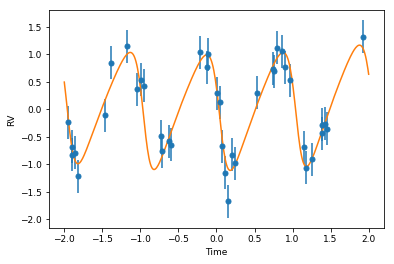

In [7]:
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )
plot_results(post.likelihood)

Use mcmc to sample the posterior distribution
========================

1. use `emcee` package to run MCMC
1. corner plot visualizes parameters and correlations
1. Blue lines show the synthetic model parameters

In [8]:
df = radvel.mcmc(post,nwalkers=20,nrun=1000)

8000/160000 (5.0%) steps complete; Running 14613.41 steps/s; Mean acceptance rate = 47.8%; Min Tz = 1521.6; Max G-R = 1.02      
Discarding burn-in now that the chains are marginally well-mixed

136000/160000 (85.0%) steps complete; Running 12335.68 steps/s; Mean acceptance rate = 43.7%; Min Tz = 4191.3; Max G-R = 1.01      
Chains are well-mixed after 136000 steps! MCMC completed in 10.4 seconds




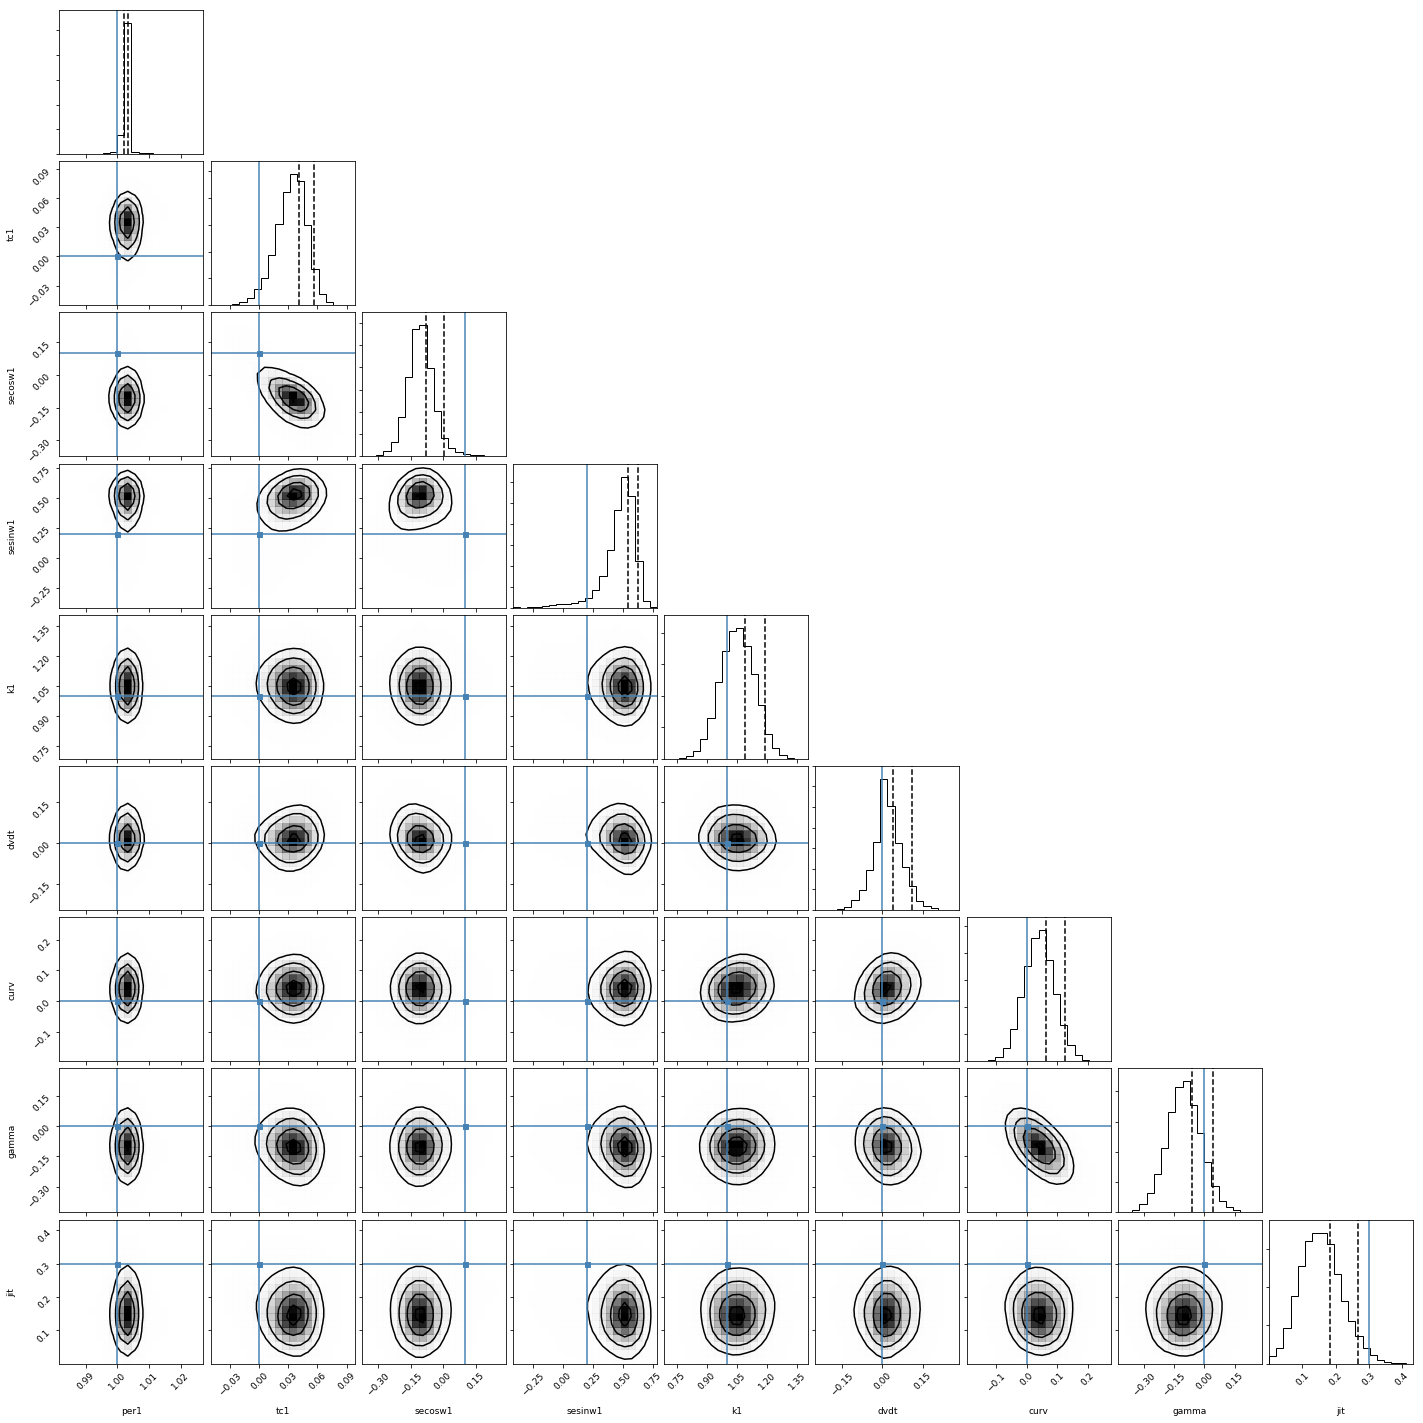

In [9]:
labels = [k for k in post.params.keys() if post.params[k].vary]



fig = corner.corner(
    df[labels],
    labels=labels,
    truths=[truths[k].value for k in labels ],
    quantiles=[0.68,0.95],
    plot_datapoints=False,
    smooth=True,
    bins=20
    )

(array([  1.20000000e+01,   7.90000000e+01,   2.93000000e+02,
          1.09700000e+03,   3.34400000e+03,   9.78800000e+03,
          2.06680000e+04,   3.77550000e+04,   4.28510000e+04,
          1.21130000e+04]),
 array([-25.24844858, -23.16887614, -21.08930371, -19.00973127,
        -16.93015884, -14.8505864 , -12.77101396, -10.69144153,
         -8.61186909,  -6.53229666,  -4.45272422]),
 <a list of 10 Patch objects>)

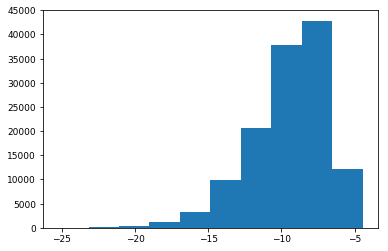

In [10]:
hist(df.lnprobability)